<a href="https://colab.research.google.com/github/jyothsna1402/Tasks/blob/main/TSF_Task_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Task-7:  Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines**

###**1 Downloading Datasets | Stock Price Data | News Headlines Data**

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost 
import lightgbm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
!pip install pmdarima

In [ ]:
df_prices = pd.read_csv('/content/sample_data/BSESN.csv')
print(df_prices.head())
print(df_prices.size)

         Date         Open         High  ...        Close    Adj Close  Volume
0  1997-07-01  4263.109863  4301.770020  ...  4300.859863  4300.859863     0.0
1  1997-07-02  4302.959961  4395.310059  ...  4333.899902  4333.899902     0.0
2  1997-07-03  4335.790039  4393.290039  ...  4323.459961  4323.459961     0.0
3  1997-07-04  4332.700195  4347.589844  ...  4323.819824  4323.819824     0.0
4  1997-07-07  4326.810059  4391.009766  ...  4291.450195  4291.450195     0.0

[5 rows x 7 columns]
40810


In [ ]:
#Converting Date column to datetime datatype
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5830 entries, 0 to 5829
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5830 non-null   datetime64[ns]
 1   Open       5702 non-null   float64       
 2   High       5702 non-null   float64       
 3   Low        5702 non-null   float64       
 4   Close      5702 non-null   float64       
 5   Adj Close  5702 non-null   float64       
 6   Volume     5702 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 319.0 KB


In [ ]:
df_prices.dropna(inplace = True)

Text(0, 0.5, 'Close')

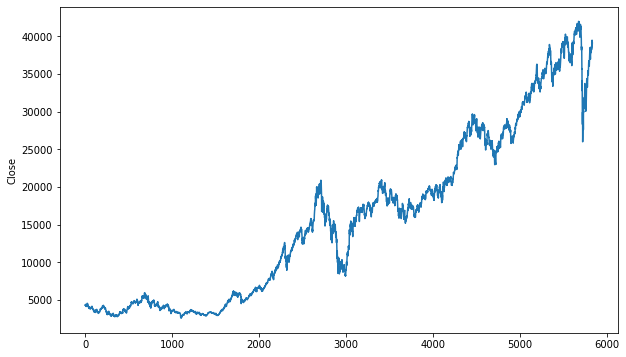

In [ ]:
plt.figure(figsize=(10, 6))
df_prices['Close'].plot()
plt.ylabel('Close')

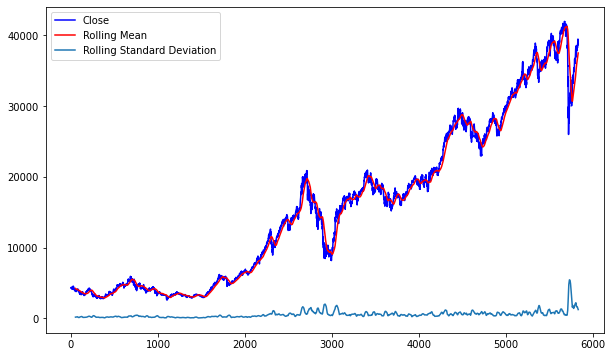

In [ ]:
#Plotting moving average
close = df_prices['Close']
ma = close.rolling(window = 50).mean()
std = close.rolling(window = 50).std()

plt.figure(figsize=(10, 6))
df_prices['Close'].plot(color = 'b', label = 'Close')
ma.plot(color = 'r', label = 'Rolling Mean')
std.plot(label = 'Rolling Standard Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

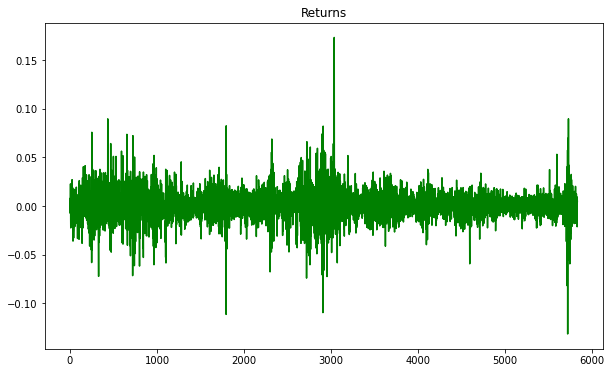

In [ ]:
#Plotting returns
returns = close / close.shift(1) - 1

plt.figure(figsize = (10,6))
returns.plot(label='Return', color = 'g')
plt.title("Returns")

In [ ]:
train = df_prices[:1000]
test = df_prices[1000:]

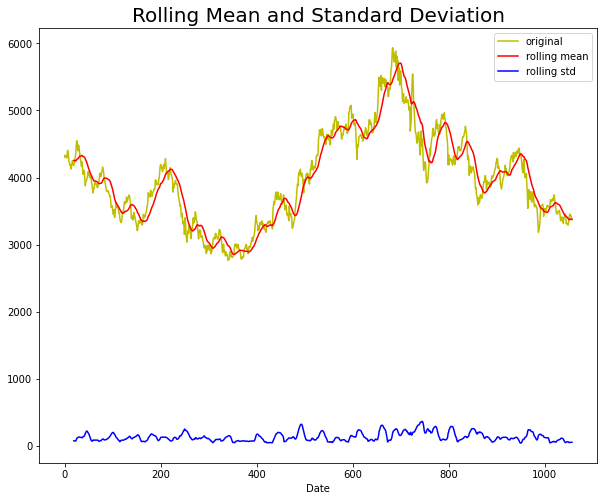

Results of dickey fuller test
ADF Test Statistic : -1.8735252065072987
p-value : 0.3446163246726278
#Lags Used : 9
Number of Observations Used : 990
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
#Stationarity test
def test_stationarity(timeseries):

 #Determing rolling statistics
 rolmean = timeseries.rolling(20).mean()
 rolstd = timeseries.rolling(20).std()

 #Plot rolling statistics:
 plt.figure(figsize = (10,8))
 plt.plot(timeseries, color = 'y', label = 'original')
 plt.plot(rolmean, color = 'r', label = 'rolling mean')
 plt.plot(rolstd, color = 'b', label = 'rolling std')
 plt.xlabel('Date')
 plt.legend()
 plt.title('Rolling Mean and Standard Deviation',  fontsize = 20)
 plt.show(block = False)
 
 print('Results of dickey fuller test')
 result = adfuller(timeseries, autolag = 'AIC')
 labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
 for value,label in zip(result, labels):
   print(label+' : '+str(value) )
 if result[1] <= 0.05:
   print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
 else:
   print("Weak evidence against null hypothesis, time series is non-stationary ")
test_stationarity(train['Close'])

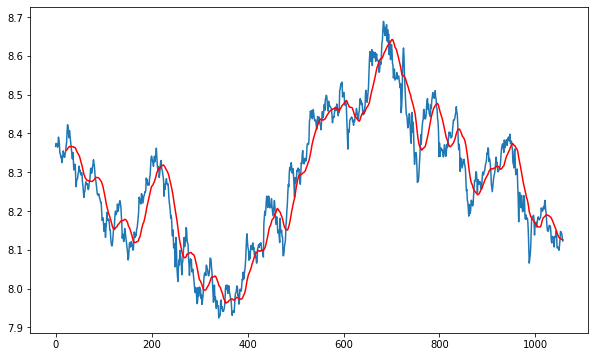

In [ ]:
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])

mav = train_log.rolling(24).mean() 
plt.figure(figsize = (10,6))
plt.plot(train_log) 
plt.plot(mav, color = 'red')

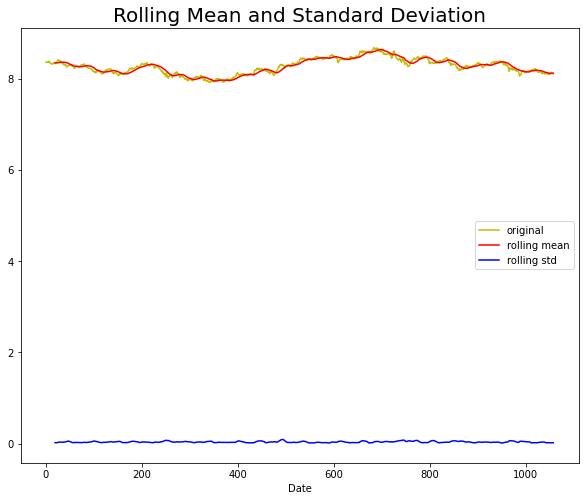

Results of dickey fuller test
ADF Test Statistic : -1.8671689508635314
p-value : 0.34765992827223324
#Lags Used : 9
Number of Observations Used : 990
Weak evidence against null hypothesis, time series is non-stationary 


In [ ]:
train_log.dropna(inplace = True)
test_log.dropna(inplace = True)

test_stationarity(train_log)

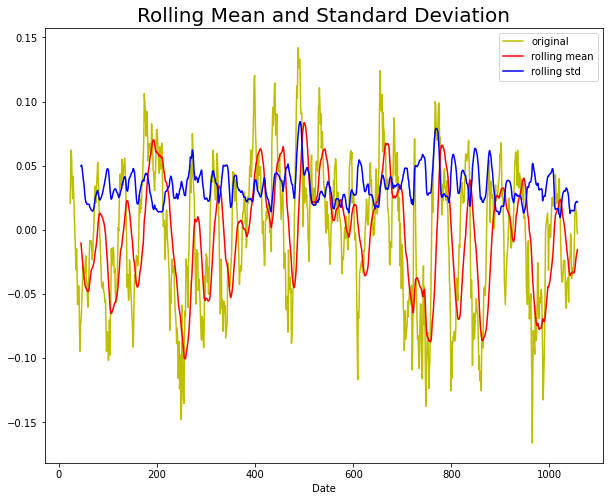

Results of dickey fuller test
ADF Test Statistic : -6.97219935256516
p-value : 8.607477708608758e-10
#Lags Used : 9
Number of Observations Used : 967
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [ ]:
train_log_diff = train_log - mav
train_log_diff.dropna(inplace = True)

test_stationarity(train_log_diff)

In [ ]:
#Using auto arima to make predictions using log data
from pmdarima import auto_arima
model = auto_arima(train_log, trace = True, error_action = 'ignore', suppress_warnings = True)
model.fit(train_log)
predictions = model.predict(n_periods = len(test))
predictions = pd.DataFrame(predictions,index = test_log.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5096.664, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5099.231, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5099.479, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5098.497, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5098.059, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5098.045, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5096.154, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5101.333, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5099.908, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5099.892, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5101.085, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-5098.003, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 3.318 seconds


Text(0, 0.5, 'Actual Stock Price')

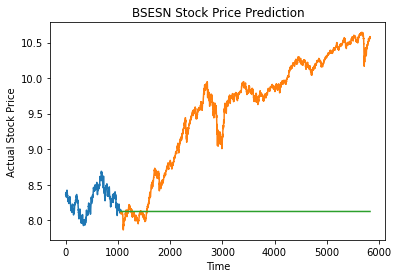

In [ ]:
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('BSESN Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')

In [ ]:
#Calculating error
rms = np.sqrt(mean_squared_error(test_log,predictions))
print("RMSE : ", rms)

RMSE :  1.660644287415502


###**TEXTUAL ANALYSIS**

In [ ]:
cols = ['Date','Category','News']
df_news = pd.read_csv('/content/sample_data/india-news-headlines.csv', names = cols)
df_news

,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
...,...,...,...
1048571,20110123,city.lucknow,Police recover 100 'improper' SIMs
1048572,20110123,city.lucknow,5 new KGBVs for Lucknow
1048573,20110123,india,70% can't afford sanitary napkins; reveals study
1048574,20110123,city.lucknow,Cops ask internet cafe; PCO owners to be more ...


In [ ]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 1 to 1048575
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Date    1048575 non-null  object
 1   News    1048575 non-null  object
dtypes: object(2)
memory usage: 24.0+ MB


In [ ]:
#Converting data type of Date column 
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news

,Date,News
1,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,Fissures in Hurriyat over Pak visit
3,2001-01-02,America's unwanted heading for India?
4,2001-01-02,For bigwigs; it is destination Goa
5,2001-01-02,Extra buses to clear tourist traffic
...,...,...
1048571,2011-01-23,Police recover 100 'improper' SIMs
1048572,2011-01-23,5 new KGBVs for Lucknow
1048573,2011-01-23,70% can't afford sanitary napkins; reveals study
1048574,2011-01-23,Cops ask internet cafe; PCO owners to be more ...


In [ ]:
#Grouping the headlines for each day
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
3627,2011-01-19,My ex doesn't want me: Pratik Saali is not a g...
3628,2011-01-20,Neetu Chandra denies going panty-less! Aishwar...
3629,2011-01-21,Giving the kids a dressing up AK Hangal's ill ...
3630,2011-01-22,DTE seeks report from tech institutes Corporat...


In [ ]:
df_news['News']

0       Status quo will not be disturbed at Ayodhya; s...
1       Powerless north India gropes in the dark Think...
2       The string that pulled Stephen Hawking to Indi...
3       Light combat craft takes India into club class...
4       Light combat craft takes India into club class...
                              ...                        
3627    My ex doesn't want me: Pratik Saali is not a g...
3628    Neetu Chandra denies going panty-less! Aishwar...
3629    Giving the kids a dressing up AK Hangal's ill ...
3630    DTE seeks report from tech institutes Corporat...
3631    Delhi Daredevils Mumbai Indians Chennai Super ...
Name: News, Length: 3632, dtype: object

In [ ]:
#Cleaning headlines
c = []
for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    ps = PorterStemmer()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    c.append(news)

In [ ]:
df_news['News'] = pd.Series(c)
df_news

,Date,News
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...
1,2001-01-03,powerless north india grope dark think laxman ...
2,2001-01-04,string pull stephen hawk india vajpaye give bi...
3,2001-01-05,light combat craft take india club class hawk ...
4,2001-01-06,light combat craft take india club class hawk ...
...,...,...
3627,2011-01-19,ex want pratik saali gaali sudhir tell sharmil...
3628,2011-01-20,neetu chandra deni go panti less aishwarya aam...
3629,2011-01-21,give kid dress ak hangal ill broke dhobi ghat ...
3630,2011-01-22,dte seek report tech institut corpor oppos kot...


In [ ]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [ ]:
#Adding subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news

,Date,News,Subjectivity,Polarity
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394
...,...,...,...,...
3627,2011-01-19,ex want pratik saali gaali sudhir tell sharmil...,0.350529,0.088851
3628,2011-01-20,neetu chandra deni go panti less aishwarya aam...,0.336776,0.063600
3629,2011-01-21,give kid dress ak hangal ill broke dhobi ghat ...,0.365818,0.023326
3630,2011-01-22,dte seek report tech institut corpor oppos kot...,0.389635,0.041496


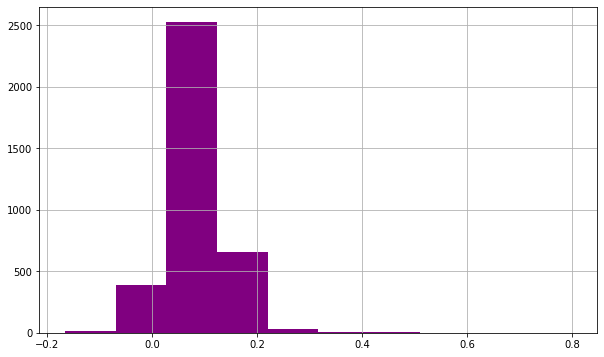

In [ ]:
plt.figure(figsize = (10,6))
df_news['Polarity'].hist(color = 'purple')

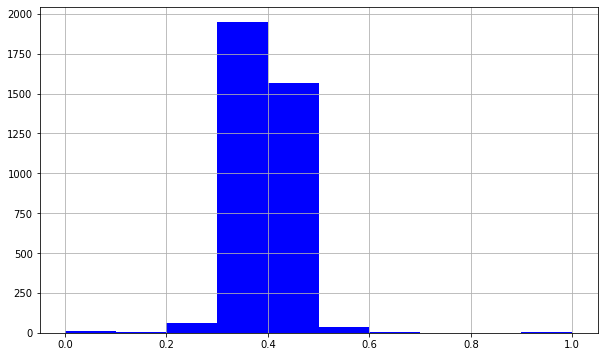

In [ ]:
plt.figure(figsize = (10,6))
df_news['Subjectivity'].hist(color = 'blue')

In [ ]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,2001-01-03,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,2001-01-04,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,2001-01-05,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,2001-01-06,light combat craft take india club class hawk ...,0.425758,0.389394,-0.7579,0.207,0.649,0.144
...,...,...,...,...,...,...,...,...
3627,2011-01-19,ex want pratik saali gaali sudhir tell sharmil...,0.350529,0.088851,-0.9997,0.128,0.794,0.078
3628,2011-01-20,neetu chandra deni go panti less aishwarya aam...,0.336776,0.063600,-0.9996,0.129,0.785,0.086
3629,2011-01-21,give kid dress ak hangal ill broke dhobi ghat ...,0.365818,0.023326,-0.9999,0.151,0.768,0.081
3630,2011-01-22,dte seek report tech institut corpor oppos kot...,0.389635,0.041496,-0.9997,0.135,0.782,0.083


In [ ]:
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0.0,statu quo disturb ayodhya say vajpaye fissur h...,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0.0,powerless north india grope dark think laxman ...,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0.0,string pull stephen hawk india vajpaye give bi...,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0.0,light combat craft take india club class hawk ...,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0.0,sangh parivar babri panel ant frontrunn key us...,0.486204,-0.035142,-0.6808,0.100,0.816,0.084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2452,2011-01-17,18911.429688,19018.939453,18779.380859,18882.250000,18882.250000,17800.0,older brother dark sibl death thought superman...,0.364148,0.058013,-0.9997,0.146,0.756,0.098
2453,2011-01-18,18983.199219,19120.619141,18933.470703,19092.050781,19092.050781,14400.0,top sex mistak men make alcohol pack salman sr...,0.358898,0.086609,-0.9998,0.152,0.770,0.078
2454,2011-01-19,19153.310547,19167.060547,18898.560547,18978.320313,18978.320313,16200.0,ex want pratik saali gaali sudhir tell sharmil...,0.350529,0.088851,-0.9997,0.128,0.794,0.078
2455,2011-01-20,18892.429688,19100.259766,18794.730469,19046.539063,19046.539063,12800.0,neetu chandra deni go panti less aishwarya aam...,0.336776,0.063600,-0.9996,0.129,0.785,0.086


In [ ]:
df = df_merge[['Close','Subjectivity', 'Polarity', 'Compound', 'Negative', 'Neutral' ,'Positive']]
df

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,4018.879883,0.298148,0.099074,-0.8555,0.125,0.773,0.102
1,4060.020020,0.429167,0.025000,-0.5994,0.132,0.755,0.113
2,4115.370117,0.475140,0.032481,0.9169,0.099,0.791,0.110
3,4183.729980,0.458412,0.296404,-0.3612,0.171,0.659,0.170
4,4120.430176,0.486204,-0.035142,-0.6808,0.100,0.816,0.084
...,...,...,...,...,...,...,...
2452,18882.250000,0.364148,0.058013,-0.9997,0.146,0.756,0.098
2453,19092.050781,0.358898,0.086609,-0.9998,0.152,0.770,0.078
2454,18978.320313,0.350529,0.088851,-0.9997,0.128,0.794,0.078
2455,19046.539063,0.336776,0.063600,-0.9996,0.129,0.785,0.086


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_df = pd.DataFrame(sc.fit_transform(df))
new_df.columns = df.columns
new_df.index = df.index
new_df.head()

,Close,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.077391,0.298148,0.404464,0.072207,0.382263,0.699735,0.134921
1,0.079635,0.429167,0.287402,0.200270,0.403670,0.675926,0.149471
2,0.082654,0.475140,0.299225,0.958496,0.302752,0.723545,0.145503
3,0.086383,0.458412,0.716311,0.319382,0.522936,0.548942,0.224868
4,0.082930,0.486204,0.192357,0.159566,0.305810,0.756614,0.111111


In [ ]:
X = new_df.drop('Close', axis=1)
y =new_df['Close']

In [ ]:
X.head()

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,0.298148,0.404464,0.072207,0.382263,0.699735,0.134921
1,0.429167,0.287402,0.200270,0.403670,0.675926,0.149471
2,0.475140,0.299225,0.958496,0.302752,0.723545,0.145503
3,0.458412,0.716311,0.319382,0.522936,0.548942,0.224868
4,0.486204,0.192357,0.159566,0.305810,0.756614,0.111111


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
x_train.shape

(1965, 6)

In [ ]:
x_train[:10]

,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
229,0.394541,0.502317,0.013351,0.336391,0.714286,0.138889
581,0.358736,0.338708,0.001500,0.415902,0.679894,0.140212
200,0.390131,0.382929,0.000800,0.394495,0.701058,0.128307
1680,0.335868,0.367705,0.001050,0.391437,0.738095,0.093915
2068,0.412907,0.378233,0.000050,0.513761,0.653439,0.124339
2093,0.395759,0.399242,0.000050,0.480122,0.681217,0.111111
1980,0.362617,0.391030,0.001700,0.467890,0.619048,0.178571
1490,0.284133,0.206838,0.001600,0.418960,0.727513,0.091270
1789,0.379761,0.275170,0.000300,0.541284,0.619048,0.145503
828,0.441326,0.444282,0.005201,0.431193,0.653439,0.160053


In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [ ]:
print(prediction[:10])
print(y_test[:10])
print(mean_squared_error(prediction,y_test))

[0.29642962 0.39273624 0.59076884 0.36527941 0.41394986 0.26677396
 0.17655909 0.31507634 0.34177672 0.28937225]
1257    0.437841
1338    0.436885
1665    0.866922
712     0.161693
2077    0.631142
330     0.040600
156     0.006294
1412    0.563379
1173    0.293174
1794    0.812267
Name: Close, dtype: float64
0.08526851582848684


In [ ]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)
predictions = adb.predict(x_test)

In [ ]:
print(mean_squared_error(predictions, y_test))

0.08055303353682736


In [ ]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor()
dec_tree.fit(x_train, y_train)
predictions = dec_tree.predict(x_test)

In [ ]:
print(predictions[:10])
print(y_test[:10])
print(mean_squared_error(predictions,y_test))

[0.15955227 0.51440074 0.63641884 0.57125157 0.47373116 0.04373032
 0.02302157 0.18336918 0.41870003 0.507544  ]
1257    0.437841
1338    0.436885
1665    0.866922
712     0.161693
2077    0.631142
330     0.040600
156     0.006294
1412    0.563379
1173    0.293174
1794    0.812267
Name: Close, dtype: float64
0.15353897502534433


In [ ]:
lgb = lightgbm.LGBMRegressor()
lgb.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
predictions = lgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.08882180271292617


In [ ]:
xgb = xgboost.XGBRegressor()
xgb.fit(x_train, y_train)

[08:34:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
predictions = xgb.predict(x_test)
print(mean_squared_error(predictions,y_test))

0.08054861057878424


**I have used Auto-ARIMA model to make stock market prices predictions using the historical stock prices data. In the sentiment analysis model, I have made use of different machine learning algorithms-Random Forest Regressor, LightGBM, Adaboost and Xgboost- to make the predictions.**  

##**Thank You!**